## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            
            nn.Linear(256, 64),
            nn.ReLU(),
            
            nn.Linear(64, 16),
            nn.ReLU(),
            
            nn.Linear(16, num_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 64]          16,448
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 16]           1,040
              ReLU-7                   [-1, 16]               0
            Linear-8                   [-1, 10]             170
Total params: 218,618
Trainable params: 218,618
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


Your experiments come here:

In [9]:
from collections import defaultdict


def validate(valid_loader, model, criterion):    
    with torch.no_grad():
        batch_loss_valid = []
        batch_accuracy_valid = []

        for i, (images, target) in enumerate(valid_loader):
            images = images.cuda(device, non_blocking=True)
            target = target.cuda(device, non_blocking=True)
            output = model.forward(images)

            loss = criterion(output, target)
            batch_loss_valid.append(loss.item())

            accuracy = (output.argmax(axis=1) == target).cpu().numpy().mean()
            batch_accuracy_valid.append(accuracy)

        valid_loss = sum(batch_loss_valid) / len(batch_loss_valid)
        valid_accuracy = sum(batch_accuracy_valid) / len(batch_accuracy_valid)

    return valid_loss, valid_accuracy


def train(model, criterion, optimizer, train_loader, valid_loader = None, num_epochs: int = 10):
    history = defaultdict(list)

    for epoch in range(num_epochs):
        model.train()
        loss_epoch = []
        accuracy_epoch = []

        for i, (images, target) in enumerate(train_loader):
            images = images.cuda(device, non_blocking=True)
            target = target.cuda(device, non_blocking=True)
            output = model.forward(images)

            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        train_loss, train_accuracy = validate(train_loader, model, criterion)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        
        if valid_loader is not None:
            valid_loss, valid_accuracy = validate(valid_loader, model, criterion)
            history["valid_loss"].append(valid_loss)
            history["valid_accuracy"].append(valid_accuracy)

    return model, history


def plot_training_history(history):
    best_epoch = np.argmax(history["valid_accuracy"])
    print(f'Best epoch: {best_epoch}, valid_accuracy = {history["valid_accuracy"][best_epoch]}')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history["train_loss"])
    if "valid_loss" in history:
        ax1.plot(history["valid_loss"])
    ax1.axvline(x=best_epoch, color="r", linestyle="--")
    ax1.set_title("Loss")
    ax1.legend(["train", "valid"])
    
    ax2.plot(history["train_accuracy"])
    if "valid_accuracy" in history:
        ax2.plot(history["valid_accuracy"])
    ax2.axvline(x=best_epoch, color="r", linestyle="--")
    ax2.set_title("Accuracy")
    ax2.legend(["train", "valid"])

In [10]:
model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.75)
criterion = nn.CrossEntropyLoss()

model, history = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=50)

Best epoch: 48, valid_accuracy = 0.88505859375


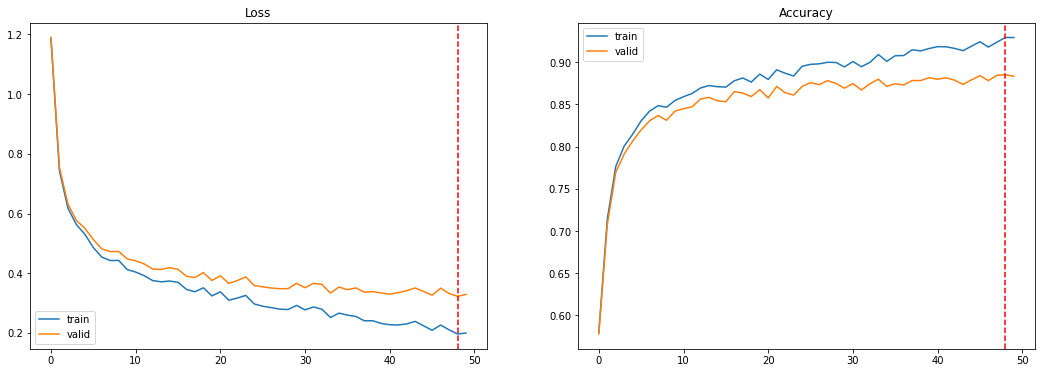

In [11]:
plot_training_history(history)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated T

In [14]:
model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.75)
criterion = nn.CrossEntropyLoss()

model, history = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=100)

Best epoch: 89, valid_accuracy = 0.89130859375


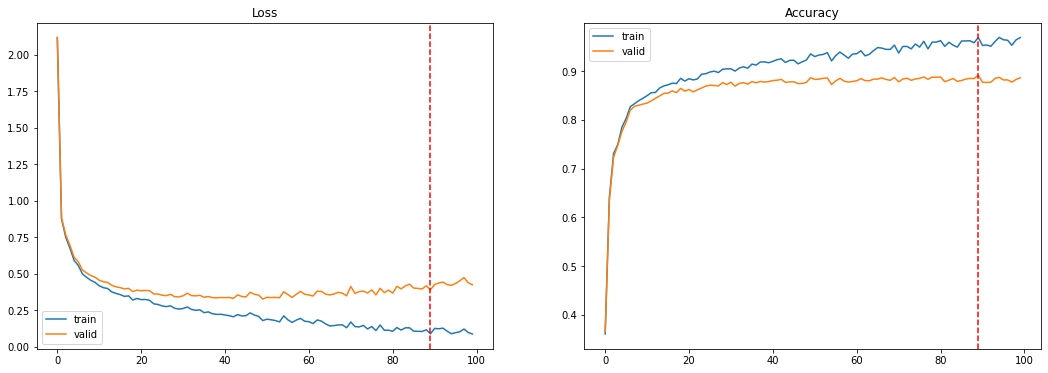

In [15]:
plot_training_history(history)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330
Total params: 244,522
Trainable params:

In [22]:
model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.75)
criterion = nn.CrossEntropyLoss()

model, history = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=100)

Best epoch: 81, valid_accuracy = 0.8935546875


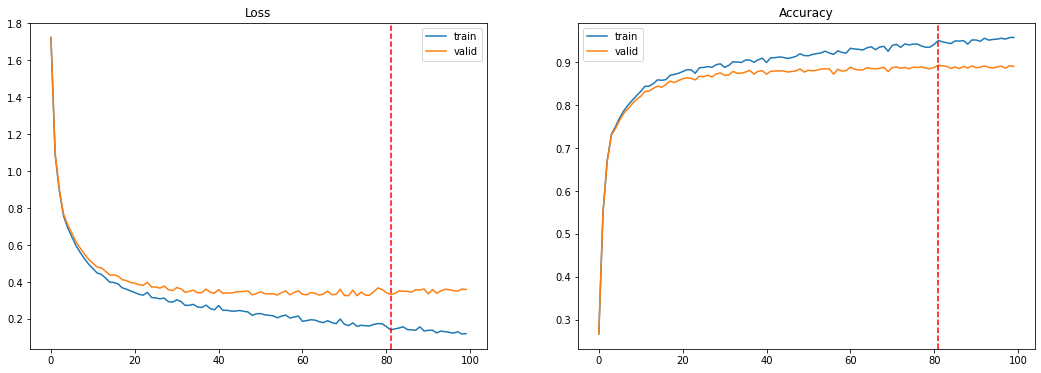

In [23]:
plot_training_history(history)

### Conclusions:
_Write down small report with your conclusions and your ideas._

При добавлении регуляризации полученная модель менее сколнна переобучиться. Также обучение ставновится более устойчивым (меньше колебание функции потерь) и улучшается точность классификации (accuracy)